## Network Dispersion on vertex level



In [13]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 
subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()

# plotting
fsaverage = fetch_surf_fsaverage() # default 5


In [ ]:
from utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

from brainspace.utils.parcellation import map_to_labels
caNets_fsav5_mapping = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]


In [52]:
# gradient values, vertex x subject
n_grad =2

gms_aligned = [None] * len(subList)
for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy')) # sub-01_g-aligned_space-fsaverag5_n10.npy
    gms_aligned[i] = gm_aligned[n_grad-1,:] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList]) 
n_vertices = np.shape(gms_aligned)[1] # 180

In [53]:
g1 = np.array(gms_aligned).T # n_vertices x n_subjects
N_nets = len(np.unique(caNets_fsav5_mapping)[1:]) # remove network-label=0

# compute for each subject and for each yeo network a) network centroid position; b) within network dispersion metric (higher value = wider distribution = more dispersion)
centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)


for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    
    # identify the nodes of given Yeo network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0] # get (glasser space) indices
    netNodes = np.squeeze(netNodes)
    
    # get the gradient loadings of the nodes of the given Yeo network, for each subject (shape: number of nodes in network x N)
    G1_net = g1[netNodes]
    
    ### identify the centroid / center of gravity (= median) of the given Yeo network for each subject (shape: N)
    centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
    centroids_net.append(centroid_cog_net)
    
    ### within network dispersion: 1 within network dispersion value per subject (per network)
    
    # compute (per subject) the Eucledian distance between each gradient loading (in Yeo network) and that network's centroid
    dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N
    
    # take the sum of squares of this Eucledian distance 
    sum_of_squares = np.nanmean((dist_nodes_to_centroid**2), axis = 0)  # shape: N # sum originally!!
    
    # append to list
    WN_dispersion.append(sum_of_squares)
    
centroids_net = np.array(centroids_net)
WN_dispersion = np.array(WN_dispersion)

In [54]:
measure_of_interest =   'Within network dispersion' #  'Network midpoint (centroid)' #

if measure_of_interest == 'Within network dispersion':
    data = WN_dispersion 
elif measure_of_interest == 'Network midpoint (centroid)':
    data = centroids_net
    
df = pd.DataFrame(np.array(data.T), index=sub_array, columns = [f"net_{i+1}" for i in range(N_nets)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

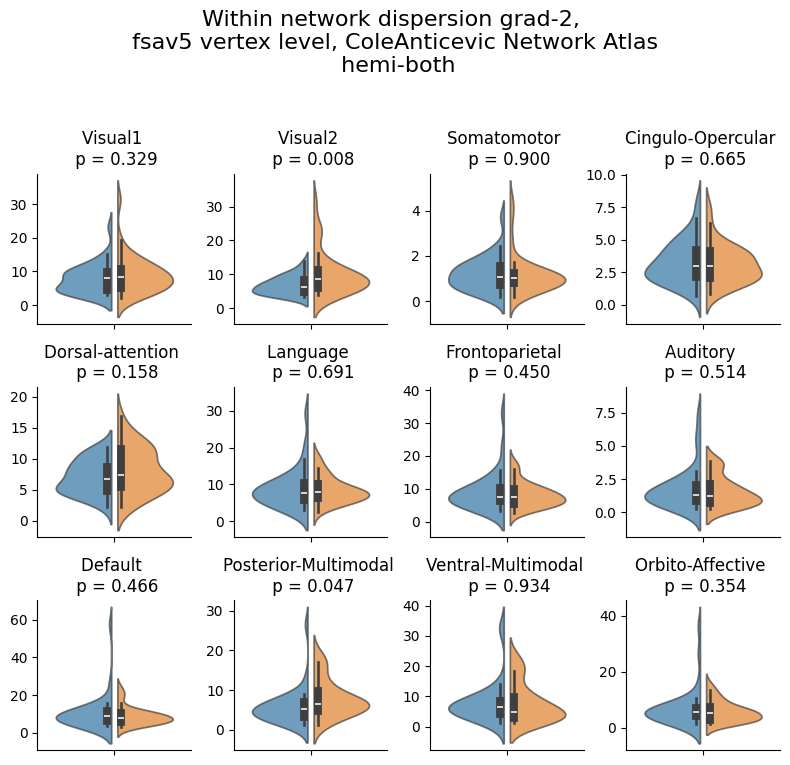

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

network_atlas = 'ColeAnticevic'
network_names = CAatlas_names
hemi = 'both'
#tmp = df.loc[df.abs().mean(axis=1) < 100].reset_index() # remove outlier subjects (weird gradient loading scale due to >1 connected components)
tmp = df.reset_index()

n_cols = 4  # Number of columns in the subplot grid
n_rows = int((N_nets) / n_cols)  # Calculate rows needed for N_nets subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8)) # , sharex=True, sharey=True
fig.suptitle(f'{measure_of_interest} grad-{n_grad}, \n fsav5 vertex level, {network_atlas} Network Atlas \n hemi-{hemi}', fontsize=16)

pvals = []
for i in range(N_nets):
    ax = axes[i // n_cols, i % n_cols]  # Calculate position in grid
    net_label_number = (i+1)
    net_name= network_names.loc[net_label_number].item()

    data_net = tmp[f'net_{i + 1}']
    _, p_value = ttest_ind(data_net[tmp['group'] == 0], data_net[tmp['group'] == 1], equal_var=False)  # Welch's t-test
    
    #sns.kdeplot(data=tmp, x=f'net_{net_label_number}', hue='group', ax=ax, fill=True,legend=False)
    sns.violinplot(data=tmp, y=f'net_{net_label_number}', hue='group', ax=ax, fill=True,legend=False,split=True, gap=.1, alpha= 0.7)
    ax.set_title(f'{net_name} \n p = {p_value:.3f}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    pvals.append(p_value)

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
plt.show()

pvals = np.array(pvals)

In [56]:
# Multiple comparison correction! 

# Apply Bonferroni correction
bonferroni_corrected_pvals = pvals * len(pvals) # np.minimum(
print(bonferroni_corrected_pvals)

# Apply Benjamini-Hochberg FDR correction
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
pvals_corrected

[ 3.94208545  0.09343398 10.79498242  7.97905061  1.90174143  8.29785465
  5.40178719  6.16328867  5.59720519  0.5635477  11.20888362  4.25181868]


array([0.77041108, 0.09343398, 0.93407364, 0.82978547, 0.63391381,
       0.82978547, 0.77041108, 0.77041108, 0.77041108, 0.28177385,
       0.93407364, 0.77041108])

In [57]:
# Between network
BN_dispersions = {'pairwise_comparison' : [], 'net_name_comp' : [], 't_stats': [], 'p_vals': []} #, 'distances':[]}

N_nets = 12

mat = np.zeros([N_nets, N_nets])
distances = []
for n1 in range(N_nets):
    for n2 in range(N_nets):
        current_pairwise_comparison = [n1+1, n2+1]
        if n1!=n2 and [n1+1, n2+1] not in BN_dispersions['pairwise_comparison'] and list(reversed([n1+1, n2+1])) not in BN_dispersions['pairwise_comparison']:
            BN_dispersions['pairwise_comparison'].append(current_pairwise_comparison)
            distance = centroids_net[n1] - centroids_net[n2] # (12, 66)
            distances.append(distance)

            df = pd.DataFrame(np.array(distance.T), index=sub_array)
            df.index.name = 'subject'
            df = df.join(group_list).set_index('group',append=True)
            t_stat, p_val = ttest_ind(df.xs(0,0,'group'), df.xs(1,0,'group'), equal_var=False)  # Welch's t-test
            BN_dispersions['t_stats'].append(t_stat[0])
            BN_dispersions['p_vals'].append(p_val[0])

            #BN_dispersions['net_name_comp'].append(str({CAatlas_names.loc[n1+1]['Network Name'] - {CAatlas_names.loc[n2+1]['Network Name']}')
            BN_dispersions['net_name_comp'].append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']) )

            mat[n1,n2] = t_stat[0]

df = pd.DataFrame(BN_dispersions).set_index('net_name_comp') # n_rows = 1 + 2 + .....(N-1) & N=12




Text(0.5, 1.1, 'Between network distance group difference (T-stat) \n Grad 2')

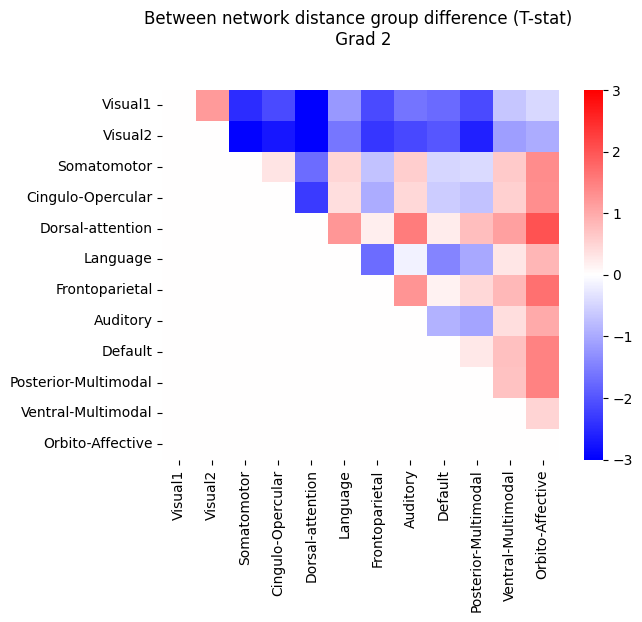

In [58]:
sns.heatmap(mat, cmap='bwr',vmin=-3,vmax=3,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Between network distance group difference (T-stat) \n Grad {n_grad}', y=1.1)

Text(0.5, 1.1, 'Grad 2, fsav5')

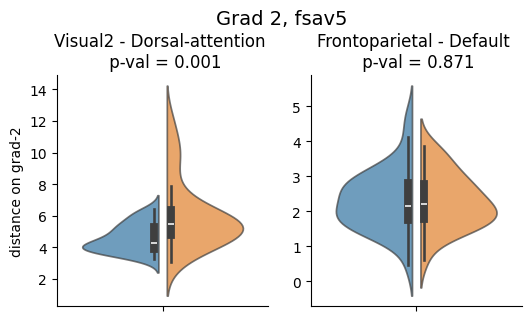

In [59]:

df_dist = pd.DataFrame(np.array(distances).T, index=sub_array, columns=BN_dispersions['net_name_comp'])
df_dist.index.name = 'subject'
df_dist = df_dist.join(group_list).set_index('group',append=True)

network_combinations = ['Visual2 - Dorsal-attention','Frontoparietal - Default' ]
fig, axes = plt.subplots(1,len(network_combinations), figsize=(len(network_combinations) * 3,3)) # , sharex=True, sharey=True

for i, net_comb in enumerate(network_combinations):
    sns.violinplot(df_dist.reset_index(),y=net_comb, hue='group',ax=axes[i],split=True, gap=.1, alpha= 0.7,legend=False)
    p_val = np.round(df.loc[net_comb]['p_vals'],3)
    axes[i].set(title=f'{net_comb} \n p-val = {p_val}', ylabel='')
sns.despine()
axes[0].set(ylabel=f'distance on grad-{n_grad}')
fig.suptitle(f'Grad {n_grad}, fsav5', fontsize=14,y=1.1)


### 2D distances

In [60]:
# gradient values, vertex x subject
gms_aligned_g1 = [None] * len(subList)
gms_aligned_g2 = [None] * len(subList)

for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy')) # sub-01_g-aligned_space-fsaverag5_n10.npy
    gms_aligned_g1[i] = gm_aligned[0,:] # only one grad to start with
    gms_aligned_g2[i] = gm_aligned[1,:] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList]) 
n_vertices = np.shape(gms_aligned)[1] # 

In [61]:
g1 = np.array(gms_aligned_g1).T  # n_vertices x n_subjects
g2 = np.array(gms_aligned_g2).T 

centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)
for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    
    # Identify the nodes of the given Yeo network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0]  # get (Glasser space) indices
    netNodes = np.squeeze(netNodes)
    
    # Get the gradient loadings of the nodes for the given Yeo network, for each subject
    G1_net = g1[netNodes]  # shape: number of nodes in network x N
    G2_net = g2[netNodes]  # shape: number of nodes in network x N
    
    # Stack gradients into a 3D array for easier 2D centroid computation
    G_net = np.stack([G1_net, G2_net], axis=-1)  # shape: number of nodes in network x N x 2
    
    # Compute the centroid (median) for the given Yeo network in 2D for each subject
    centroid_cog_net = np.nanmedian(G_net, axis=0)  # shape: N x 2
    centroids_net.append(centroid_cog_net)
    
    # Compute the 2D Euclidean distance between each node and the centroid for each subject
    dist_nodes_to_centroid = G_net - centroid_cog_net  # shape: number of nodes in network x N x 2
    squared_distances = np.sum(dist_nodes_to_centroid**2, axis=-1)  # sum squares across 2D (last axis), shape: number of nodes in network x N
    
    # Compute the within-network dispersion as the mean squared distance
    mean_squared_distances = np.nanmean(squared_distances, axis=0)  # shape: N
    WN_dispersion.append(mean_squared_distances)

# Convert results to arrays for easier handling
centroids_net = np.array(centroids_net)  # shape: 7 x N x 2 (assuming 7 networks and N subjects)
WN_dispersion = np.array(WN_dispersion)

In [80]:
measure_of_interest =   'Within network dispersion' #  'Network midpoint (centroid)' #

if measure_of_interest == 'Within network dispersion':
    data = WN_dispersion 
elif measure_of_interest == 'Network midpoint (centroid)':
    data = centroids_net
    
df = pd.DataFrame(np.array(data.T), index=sub_array, columns = [f"net_{i+1}" for i in range(N_nets)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

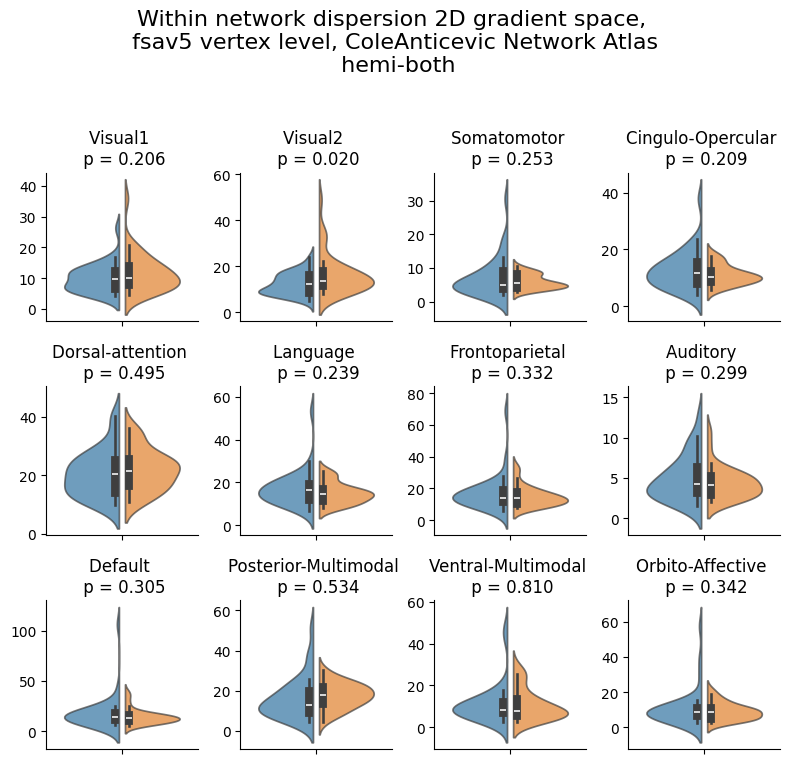

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

network_atlas = 'ColeAnticevic'
network_names = CAatlas_names
hemi = 'both'
#tmp = df.loc[df.abs().mean(axis=1) < 100].reset_index() # remove outlier subjects (weird gradient loading scale due to >1 connected components)
tmp = df.reset_index()

n_cols = 4  # Number of columns in the subplot grid
n_rows = int((N_nets) / n_cols)  # Calculate rows needed for N_nets subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8)) # , sharex=True, sharey=True
fig.suptitle(f'{measure_of_interest} 2D gradient space, \n fsav5 vertex level, {network_atlas} Network Atlas \n hemi-{hemi}', fontsize=16)

pvals = []
for i in range(N_nets):
    ax = axes[i // n_cols, i % n_cols]  # Calculate position in grid
    net_label_number = (i+1)
    net_name= network_names.loc[net_label_number].item()

    data_net = tmp[f'net_{i + 1}']
    _, p_value = ttest_ind(data_net[tmp['group'] == 0], data_net[tmp['group'] == 1], equal_var=False)  # Welch's t-test
    
    #sns.kdeplot(data=tmp, x=f'net_{net_label_number}', hue='group', ax=ax, fill=True,legend=False)
    sns.violinplot(data=tmp, y=f'net_{net_label_number}', hue='group', ax=ax, fill=True,legend=False,split=True, gap=.1, alpha= 0.7)

    ax.set_title(f'{net_name} \n p = {p_value:.3f}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    pvals.append(p_value)

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
plt.show()

pvals = np.array(pvals)

## Look at network dispersion 

In [124]:
np.shape(gms_aligned_g2)

(66, 20484)

In [125]:
n_grad = 1
gms = gms_aligned_g2 if n_grad == 2 else gms_aligned_g1
df = pd.DataFrame(gms, index=sub_array, columns = [f"vertex_{i+1}" for i in range(np.shape(gms_aligned_g1)[1])])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

df = pd.DataFrame(np.array([df.xs(0,0,'group').mean().values, df.xs(1,0,'group').mean().values, caNets_fsav5_mapping]).T,
                         columns =['control','dyscalc','ca_network' ]) 


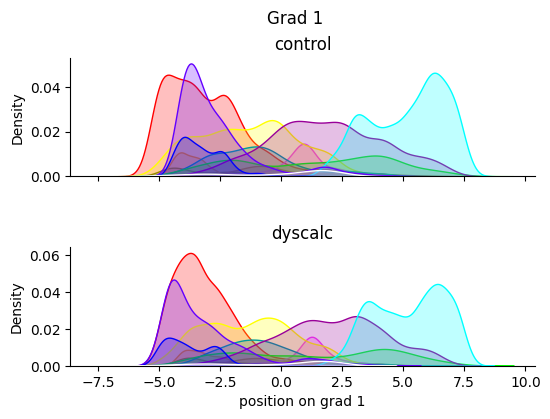

In [126]:
import hcp_utils as hcp
from matplotlib.colors import ListedColormap
import seaborn as sns
rgb = np.array(list(hcp.ca_network['rgba'].values())[1:])
ca_cmap = ListedColormap(np.vstack(([1, 1, 1, 1], rgb)), 'custom_colormap') # add white infront, 0=unknown, 1-12 actual labels

fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
sns.kdeplot(df,hue='ca_network',x='control',fill=True,palette=ca_cmap, ax=axs[0],legend=False )
sns.kdeplot(df,hue='ca_network',x='dyscalc',fill=True,palette=ca_cmap, ax=axs[1],legend=False )
fig.subplots_adjust(hspace=0.6)
axs[0].set(title='control')#, xlim=(-6.5,9))
axs[1].set(title='dyscalc', xlabel=f'position on grad {n_grad}')#, xlim=(-6.5,9))
fig.suptitle(f'Grad {n_grad}',y=1)

sns.despine()


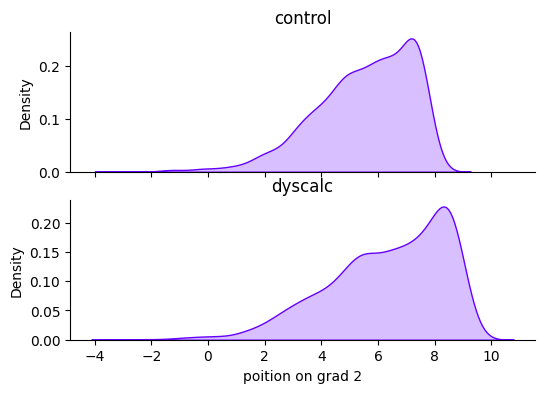

In [ ]:
network_label = 2
temp = df[df['ca_network'] == network_label]
fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
sns.kdeplot(temp,x='control',fill=True,color=rgb[int(network_label-1)], ax=axs[0],legend=False )
sns.kdeplot(temp,x='dyscalc',fill=True,color=rgb[int(network_label-1)], ax=axs[1],legend=False )
axs[0].set(title='control')#, xlim=(-6.5,9))
axs[1].set(title='dyscalc', xlabel=f'position on grad {n_grad}')#, xlim=(-6.5,9))
sns.despine()


In [ ]:
gms_g1 =  pd.DataFrame(gms_aligned_g1, index=sub_array).join(group_list).set_index('group',append=True)
gms_g2 =  pd.DataFrame(gms_aligned_g2, index=sub_array).join(group_list).set_index('group',append=True)

# dropping "outlier" 43 does not change the pattern
#gms_g1 =  pd.DataFrame(gms_aligned_g1, index=sub_array).drop(43).join(group_list).set_index('group',append=True)
#gms_g2 =  pd.DataFrame(gms_aligned_g2, index=sub_array).drop(43).join(group_list).set_index('group',append=True)

grads = np.array([gms_g1.groupby('group').mean().loc[0], gms_g1.groupby('group').mean().loc[1],
                  gms_g2.groupby('group').mean().loc[0], gms_g2.groupby('group').mean().loc[1], 
                  caNets_fsav5_mapping])
df = pd.DataFrame(grads.T, columns =['g1_control','g1_dyscalc','g2_control','g2_dyscalc','ca_network']) 

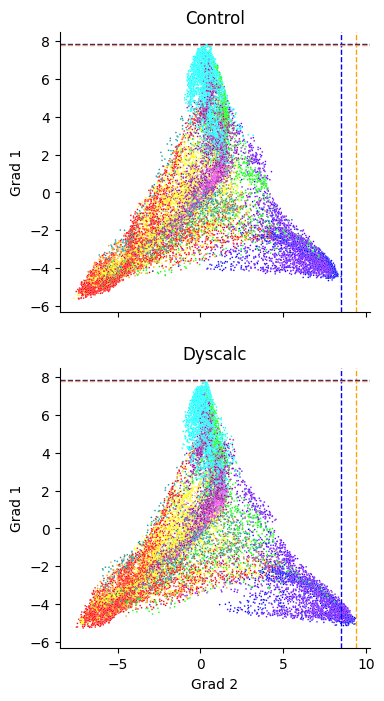

In [140]:
fig, axs = plt.subplots(2,1,figsize=(4,8), sharex=True, sharey=True)

sns.scatterplot(df, x='g2_control', y='g1_control', hue='ca_network',palette=ca_cmap,s=1.4, legend=False,ax=axs[0] )
sns.scatterplot(df, x='g2_dyscalc', y='g1_dyscalc', hue='ca_network',palette=ca_cmap,s=1.4, legend=False,ax=axs[1] )
axs[1].set(title='Dyscalc',xlabel='Grad 2',ylabel='Grad 1')
axs[0].set(title='Control',ylabel='Grad 1')

# Add guiding line
for ax in axs:
    ax.axvline(x=df['g2_control'].max(), color='blue', linestyle='--', linewidth=1)
    ax.axvline(x=df['g2_dyscalc'].max(), color='orange', linestyle='--', linewidth=1)
    ax.axhline(y=df['g1_control'].max(), color='blue', linestyle='--', linewidth=1)
    ax.axhline(y=df['g1_dyscalc'].max(), color='orange', linestyle='--', linewidth=1)

sns.despine()

## Correlation with behavior??

In [81]:
df.head()

,,net_1,net_2,net_3,net_4,net_5,net_6,net_7,net_8,net_9,net_10,net_11,net_12
subject,group,,,,,,,,,,,,
21,0,12.291831,16.357658,3.175038,10.274624,28.477116,11.695878,10.477223,3.443288,12.515312,12.907987,4.611895,4.330871
59,0,7.340105,17.792882,10.125965,23.569352,39.595146,53.359687,68.917425,12.731855,106.230999,15.781242,47.867031,57.560296
54,0,11.701625,20.919832,5.665121,11.211668,22.425868,23.851637,27.578670,5.634551,23.819797,7.686503,20.103243,28.617451
15,0,16.771982,13.308850,3.330912,18.077508,24.414747,20.850336,11.697591,6.125749,14.782500,17.120337,11.213432,11.419249
52,0,7.602463,9.003094,1.949647,3.818997,11.185893,6.844573,8.208531,1.943724,8.617138,9.820366,6.737569,4.558112


In [121]:
source_folder = op.join(bids_folder, 'derivatives/phenotype')
magjudge_bauer_params = pd.read_csv(op.join(source_folder,f'magjudge_bauer-3_sds.csv')).set_index('subject')
vs_wm = pd.read_csv(op.join(source_folder, 'visio-spatial-WM_CBTtask-params.csv')).set_index('subject')
pana = pd.read_csv(op.join(source_folder, 'ANSacuity_panamath.csv')).set_index('subject')

df_behave = pana.join(magjudge_bauer_params).join(vs_wm).set_index('group', append=True)
df_behave.columns

Index(['weber_frac', 'Percent Correct', 'memory_noise_sd',
       'perceptual_noise_sd', 'basisscore', 'overall_score',
       'erfassungsspanne'],
      dtype='object')

In [116]:
df_comb = df.join(df_behave).drop(43).reset_index()


/tmp/ipykernel_4106834/2017231350.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_comb = df.join(df_behave).drop(43).reset_index()


/tmp/ipykernel_4106834/365039139.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_ = np.round(cor['r'][0], 2)
/tmp/ipykernel_4106834/365039139.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = np.round(cor['p-val'][0], 3)


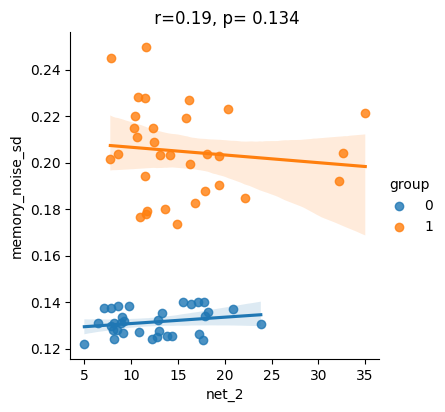

In [ ]:
import pingouin

y_var = 'memory_noise_sd' 
x_var = 'net_2'
cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'shepherd') #defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group',height=4) 
fig.set(title=f' r={r_}, p= {p}' ) 

In [103]:
df_comb[df_comb['net_2'].max() == df_comb['net_2']]

,,net_1,net_2,net_3,net_4,net_5,net_6,net_7,net_8,net_9,net_10,net_11,net_12,weber_frac,Percent Correct,memory_noise_sd,perceptual_noise_sd,basisscore,overall_score,erfassungsspanne
subject,group,,,,,,,,,,,,,,,,,,,
43,1,35.907355,48.986027,5.56951,17.791769,34.964945,14.973122,13.755797,10.881022,11.934037,21.111458,5.252436,4.427889,0.173903,82.575758,0.223925,0.042022,6,14.0,7


In [104]:
df_comb[df_comb['net_2']>20]

,,net_1,net_2,net_3,net_4,net_5,net_6,net_7,net_8,net_9,net_10,net_11,net_12,weber_frac,Percent Correct,memory_noise_sd,perceptual_noise_sd,basisscore,overall_score,erfassungsspanne
subject,group,,,,,,,,,,,,,,,,,,,
54,0,11.701625,20.919832,5.665121,11.211668,22.425868,23.851637,27.578670,5.634551,23.819797,7.686503,20.103243,28.617451,0.198102,80.303030,0.137197,0.217149,4,12.0,7
2,1,13.543725,20.341514,8.305744,10.070183,25.735934,14.500802,19.668681,5.510271,17.986204,23.959889,11.793196,9.587761,0.119873,88.257576,0.222981,0.052561,5,10.0,6
27,1,14.765598,22.131666,4.734624,11.806985,30.133852,16.991290,12.596032,4.465588,10.403828,12.087332,7.356366,10.698465,0.264441,76.136364,0.184797,0.023734,5,13.0,8
46,1,17.969579,32.578257,5.471984,9.802475,24.024594,12.704075,11.552303,2.922402,13.351856,24.576312,9.534062,7.500108,0.243674,77.651515,0.204213,0.484416,5,9.0,6
39,1,12.239419,32.163684,4.003103,13.383041,26.657592,16.809070,14.496804,5.457369,15.947904,28.123959,19.808765,14.140946,0.146022,85.606061,0.191971,0.043924,5,10.0,6
40,1,19.924806,35.011967,6.705324,6.671048,36.272194,10.666008,13.284102,2.094366,11.733482,14.178521,21.214356,11.060247,0.247402,77.272727,0.221466,0.032634,4,8.0,6
64,0,6.556635,23.844725,30.571185,37.950553,40.211009,21.908710,23.626604,5.509374,25.177131,51.356351,11.858946,8.562526,0.156378,84.090909,0.130391,0.090774,3,11.0,7
43,1,35.907355,48.986027,5.569510,17.791769,34.964945,14.973122,13.755797,10.881022,11.934037,21.111458,5.252436,4.427889,0.173903,82.575758,0.223925,0.042022,6,14.0,7


In [106]:
df_comb.drop(43)

/tmp/ipykernel_4106834/1048998462.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_comb.drop(43)


,,net_1,net_2,net_3,net_4,net_5,net_6,net_7,net_8,net_9,net_10,net_11,net_12,weber_frac,Percent Correct,memory_noise_sd,perceptual_noise_sd,basisscore,overall_score,erfassungsspanne
subject,group,,,,,,,,,,,,,,,,,,,
21,0,12.291831,16.357658,3.175038,10.274624,28.477116,11.695878,10.477223,3.443288,12.515312,12.907987,4.611895,4.330871,0.176635,82.575758,0.139185,0.145163,7,17.0,9
59,0,7.340105,17.792882,10.125965,23.569352,39.595146,53.359687,68.917425,12.731855,106.230999,15.781242,47.867031,57.560296,0.280471,75.000000,0.139985,0.084816,5,17.0,9
54,0,11.701625,20.919832,5.665121,11.211668,22.425868,23.851637,27.578670,5.634551,23.819797,7.686503,20.103243,28.617451,0.198102,80.303030,0.137197,0.217149,4,12.0,7
15,0,16.771982,13.308850,3.330912,18.077508,24.414747,20.850336,11.697591,6.125749,14.782500,17.120337,11.213432,11.419249,0.174620,83.333333,0.135295,0.080824,5,12.0,9
52,0,7.602463,9.003094,1.949647,3.818997,11.185893,6.844573,8.208531,1.943724,8.617138,9.820366,6.737569,4.558112,0.122102,88.257576,0.133488,0.116144,5,15.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0,5.545178,8.129118,3.734263,6.972808,13.591782,15.745067,12.081272,3.297033,15.678883,6.735341,4.265037,6.937966,0.389083,71.590909,0.124112,0.057638,5,17.0,9
42,1,14.990001,10.981630,3.907088,16.299475,18.255631,24.847060,17.780378,2.067252,15.300570,19.213447,11.902399,15.530038,0.227736,78.409091,0.176605,0.019536,6,12.0,6
25,1,5.675803,12.384048,6.197592,10.818032,15.894426,11.218263,9.557232,5.709285,9.897956,18.030204,3.905722,6.415652,0.193984,80.681818,0.208690,0.070733,3,5.0,5
